In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,roc_curve,auc,recall_score, precision_score,accuracy_score,matthews_corrcoef
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from torch.utils.data import random_split
import wandb


/home/minwenwen/.conda/envs/lxy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# wandb.login(key="18d6f46349c3e0570c6871db6fdbb1bb324f5573")
# wandb.init(project = "VAE")

In [3]:
torch.manual_seed(3407)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090 Ti'

In [4]:
clincal_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_Clinical.csv'
cna_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_CNA.csv'
gene_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_RNA_V2_EXP.csv'
micro_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_microbiome.csv'
label_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_label.csv'
class dataset(Dataset):
    def __init__(self, clincal_path, cna_path, gene_path, micro_path, label_path):
        super(dataset, self).__init__()
        self.clincal_data = pd.read_csv(clincal_path, index_col=0)
        self.clincal_data = torch.tensor(self.clincal_data.values, dtype=torch.float32)

        self.cna_data = pd.read_csv(cna_path, index_col=0)
        self.cna_data = torch.tensor(self.cna_data.values, dtype=torch.float32)

        self.gene_data = pd.read_csv(gene_path, index_col=0)
        self.gene_data = torch.tensor(self.gene_data.values, dtype=torch.float32)

        self.micro_data = pd.read_csv(micro_path, index_col=0)
        self.micro_data = torch.tensor(self.micro_data.values, dtype=torch.float32)

        self.label = pd.read_csv(label_path)

        self.x_data = torch.cat((self.clincal_data, self.cna_data, self.gene_data, self.micro_data), dim = 1)
        self.y_data = torch.tensor(self.label.values, dtype=torch.float32)


    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return len(self.x_data)

tcga_data = dataset(clincal_data_path, cna_data_path, gene_data_path, micro_data_path, label_data_path)
in_features = tcga_data.x_data.shape[1]

class Sample(nn.Module):
    def __init__(self):
        super(Sample, self).__init__()
    def forward(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.shape)
        eps = eps.to(device)
        std = torch.exp(z_log_var / 2)
        out = z_mean + std*eps
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
        self.z_mean = nn.Linear(32, 6)
        self.z_log_var = nn.Linear(32, 6)
        self.sample = Sample()

    def forward(self, x):
        out = self.model(x)
        z_mean = self.z_mean(out)
        z_log_var = self.z_log_var(out)
        out = self.sample(z_mean, z_log_var)
        return out, z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 50),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )

    def forward(self, z):
        out = self.model(z)
        return out

class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 200, bias = True), #input layer
            nn.BatchNorm1d(200, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(200, 400, bias = True), # 1 hidden layer
            nn.BatchNorm1d(400, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(400, 100, bias = True), # 2 hidden layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

class VAE_A(nn.Module):
    def __init__(self):
        super(VAE_A, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classfier = Classfier()
    def forward(self, x):
        x, mean, var = self.encoder(x)
        x = self.decoder(x)
        x = self.classfier(x)
        return x

# train_set, test_set = random_split(data, [749, 321])
# train_set, valid_set = random_split(train_set, [428, 321])
# train_dataloader = DataLoader(train_set, batch_size=len(train_set))
# valid_dataloader = DataLoader(valid_set, batch_size=len(valid_set))
# test_dataloader = DataLoader(test_set, batch_size=len(test_set))

model = VAE_A()
learning_rate = 1e-5
model.to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
num_epoch = 100
max_accuracy = 0
total_vae_a_y_pred = 0
total_vae_a_y_t = 0
kfold = KFold(n_splits = 5)
k_num = 1
for train_idx, valid_idx in kfold.split(tcga_data):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    train_set = Subset(tcga_data, train_idx)
    test_set = Subset(tcga_data, valid_idx)
    train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=3407)
    train_dataloader = DataLoader(train_set, batch_size=len(train_set))
    valid_dataloader = DataLoader(valid_set, batch_size=len(valid_set))
    test_dataloader = DataLoader(test_set, batch_size=len(test_set))
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for data in train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = model(x_data)
            loss = criterion(y_pred, y_t.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = model(x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                # wandb.log({'valid loss':loss})
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        # print("Validation set's Loss：{}".format(total_test_loss/num_epoch))
        if((total_accuracy/len(valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(valid_set)
            torch.save(model, "/data/minwenwen/lixiaoyu/TCGA/Model/VAE_A_Best.pth")

    model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/VAE_A_Best.pth')
    model.eval()
    with torch.no_grad():
        for data in test_dataloader:
            x_data , vae_a_y_t = data
            x_data = x_data.to(device)
            vae_a_y_t = vae_a_y_t.to(device)
            vae_a_y_pred = model(x_data)
            vae_a_y_t = vae_a_y_t.squeeze(dim = 1)

            vae_a_y_t = vae_a_y_t.cpu().numpy()
            vae_a_y_pred = vae_a_y_pred.cpu().numpy()
            vae_a_y_pred = np.amin(vae_a_y_pred, axis=1)

            total_vae_a_y_pred = np.r_[vae_a_y_pred, total_vae_a_y_pred]
            total_vae_a_y_t = np.r_[vae_a_y_t, total_vae_a_y_t]

##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.20it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.65it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.47it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.62it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.43it/s]


In [5]:
#VAE_B
class dataset(Dataset):
    def __init__(self, clincal_path, cna_path, gene_path, micro_path, label_path):
        super(dataset, self).__init__()
        self.clincal_data = pd.read_csv(clincal_path, index_col=0)
        self.clincal_data = torch.tensor(self.clincal_data.values, dtype=torch.float32)

        self.cna_data = pd.read_csv(cna_path, index_col=0)
        self.cna_data = torch.tensor(self.cna_data.values, dtype=torch.float32)

        self.gene_data = pd.read_csv(gene_path, index_col=0)
        self.gene_data = torch.tensor(self.gene_data.values, dtype=torch.float32)

        self.micro_data = pd.read_csv(micro_path, index_col=0)
        self.micro_data = torch.tensor(self.micro_data.values, dtype=torch.float32)

        self.label = pd.read_csv(label_path)

        self.x_data = torch.cat((self.clincal_data, self.cna_data, self.gene_data, self.micro_data), dim = 1)
        self.y_data = torch.tensor(self.label.values, dtype=torch.float32)


    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return len(self.x_data)

tcga_data = dataset(clincal_data_path, cna_data_path, gene_data_path, micro_data_path, label_data_path)
in_features = tcga_data.x_data.shape[1]

class Sample(nn.Module):
    def __init__(self):
        super(Sample, self).__init__()
    def forward(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.shape)
        eps = eps.to(device)
        std = torch.exp(z_log_var / 2)
        out = z_mean + std*eps
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.Dropout(p=0.45, inplace=False),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.35, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(p=0.25, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
        self.z_mean = nn.Linear(32, 6)
        self.z_log_var = nn.Linear(32, 6)
        self.sample = Sample()

    def forward(self, x):
        out = self.model(x)
        z_mean = self.z_mean(out)
        z_log_var = self.z_log_var(out)
        out = self.sample(z_mean, z_log_var)
        return out, z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.Dropout(p=0.25, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.Dropout(p=0.35, inplace=False),
            nn.ReLU(),
             nn.Linear(512, in_features),
            nn.Dropout(p=0.45, inplace=False),
            nn.ReLU()
        )

    def forward(self, z):
        out = self.model(z)
        return out

class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 200, bias = True), #input layer
            nn.BatchNorm1d(200, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(200, 400, bias = True), # 1 hidden layer
            nn.BatchNorm1d(400, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(400, 100, bias = True), # 2 hidden layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

class VAE_B(nn.Module):
    def __init__(self):
        super(VAE_B, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classfier = Classfier()
    def forward(self, x):
        x, mean, var = self.encoder(x)
        x = self.decoder(x)
        x = self.classfier(x)
        return x

# train_set, test_set = random_split(data, [749, 321])
# train_set, valid_set = random_split(train_set, [428, 321])
# train_dataloader = DataLoader(train_set, batch_size=len(train_set))
# valid_dataloader = DataLoader(valid_set, batch_size=len(valid_set))
# test_dataloader = DataLoader(test_set, batch_size=len(test_set))

model = VAE_B()

model.to(device)
# optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
num_epoch = 100
max_accuracy = 0
total_vae_b_y_pred = 0
total_vae_b_y_t = 0
kfold = KFold(n_splits = 5)
k_num = 1
for train_idx, valid_idx in kfold.split(tcga_data):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    train_set = Subset(tcga_data, train_idx)
    test_set = Subset(tcga_data, valid_idx)
    train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=3407)
    train_dataloader = DataLoader(train_set, batch_size=len(train_set))
    valid_dataloader = DataLoader(valid_set, batch_size=len(valid_set))
    test_dataloader = DataLoader(test_set, batch_size=len(test_set))
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for data in train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = model(x_data)
            loss = criterion(y_pred, y_t.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = model(x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                # wandb.log({'valid loss':loss})
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        # print("Validation set's Loss：{}".format(total_test_loss/num_epoch))
        if((total_accuracy/len(valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(valid_set)
            torch.save(model, "/data/minwenwen/lixiaoyu/TCGA/Model/VAE_B_Best.pth")

    model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/VAE_A_Best.pth')
    model.eval()
    with torch.no_grad():
        for data in test_dataloader:
            x_data , vae_b_y_t = data
            x_data = x_data.to(device)
            vae_b_y_t = vae_b_y_t.to(device)
            vae_b_y_pred = model(x_data)
            vae_b_y_t = vae_b_y_t.squeeze(dim = 1)

            vae_b_y_t = vae_b_y_t.cpu().numpy()
            vae_b_y_pred = vae_b_y_pred.cpu().numpy()
            vae_b_y_pred = np.amin(vae_b_y_pred, axis=1)

            total_vae_b_y_pred = np.r_[vae_b_y_pred, total_vae_b_y_pred]
            total_vae_b_y_t = np.r_[vae_b_y_t, total_vae_b_y_t]

##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.32it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.23it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.34it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.03it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.53it/s]


In [6]:
#VAE_C
class dataset(Dataset):
    def __init__(self, clincal_path, cna_path, gene_path, micro_path, label_path):
        super(dataset, self).__init__()
        self.clincal_data = pd.read_csv(clincal_path, index_col=0)
        self.clincal_data = torch.tensor(self.clincal_data.values, dtype=torch.float32)

        self.cna_data = pd.read_csv(cna_path, index_col=0)
        self.cna_data = torch.tensor(self.cna_data.values, dtype=torch.float32)

        self.gene_data = pd.read_csv(gene_path, index_col=0)
        self.gene_data = torch.tensor(self.gene_data.values, dtype=torch.float32)

        self.micro_data = pd.read_csv(micro_path, index_col=0)
        self.micro_data = torch.tensor(self.micro_data.values, dtype=torch.float32)

        self.label = pd.read_csv(label_path)

        self.x_data = torch.cat((self.clincal_data, self.cna_data, self.gene_data, self.micro_data), dim = 1)
        self.y_data = torch.tensor(self.label.values, dtype=torch.float32)


    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return len(self.x_data)

tcga_data = dataset(clincal_data_path, cna_data_path, gene_data_path, micro_data_path, label_data_path)
in_features = tcga_data.x_data.shape[1]

class Sample(nn.Module):
    def __init__(self):
        super(Sample, self).__init__()
    def forward(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.shape)
        eps = eps.to(device)
        std = torch.exp(z_log_var / 2)
        out = z_mean + std*eps
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
        self.z_mean = nn.Linear(32, 6)
        self.z_log_var = nn.Linear(32, 6)
        self.sample = Sample()

    def forward(self, x):
        out = self.model(x)
        z_mean = self.z_mean(out)
        z_log_var = self.z_log_var(out)
        out = self.sample(z_mean, z_log_var)
        return out, z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 50),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )

    def forward(self, z):
        out = self.model(z)
        return out

class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 200, bias = True), #input layer
            nn.BatchNorm1d(200, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(200, 400, bias = True), # 1 hidden layer
            nn.BatchNorm1d(400, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(400, 100, bias = True), # 2 hidden layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
        # self.model = nn.Sequential(
        #     nn.Linear(6, 1000, bias = True), #input layer
        #     nn.BatchNorm1d(1000, eps = 1e-03),
        #     nn.Tanh(),
        #     nn.Dropout(p=0.53, inplace=False),
        #     nn.Linear(1000, 500, bias = True), # 1 hidden layer
        #     nn.BatchNorm1d(500, eps = 1e-03),
        #     nn.Tanh(),
        #     nn.Dropout(p=0.53, inplace=False),
        #     nn.Linear(500, 500, bias = True), # 2 hidden layer
        #     nn.BatchNorm1d(500, eps = 1e-03),
        #     nn.Tanh(),
        #     nn.Dropout(p=0.53, inplace=False),
        #     nn.Linear(500, 100, bias = True), # 3 hidden layer
        #     nn.BatchNorm1d(100, eps = 1e-03),
        #     nn.Tanh(),
        #     nn.Dropout(p=0.53, inplace=False),
        #     nn.Linear(100, 2, bias = True), # 4 hidden layer
        #     nn.Softmax(dim = 1)    #outpust layer
        # )
    def forward(self, x):
        x = self.model(x)
        return x

class VAE_C(nn.Module):
    def __init__(self):
        super(VAE_C, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classfier = Classfier()
    def forward(self, x):
        x, mean, var = self.encoder(x)
        # x = self.decoder(x)
        x = self.classfier(x)
        return x

# train_set, test_set = random_split(data, [749, 321])
# train_set, valid_set = random_split(train_set, [428, 321])
# train_dataloader = DataLoader(train_set, batch_size=len(train_set))
# valid_dataloader = DataLoader(valid_set, batch_size=len(valid_set))
# test_dataloader = DataLoader(test_set, batch_size=len(test_set))

model = VAE_C()

model.to(device)
# optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
num_epoch = 100
max_accuracy = 0
total_vae_c_y_pred = 0
total_vae_c_y_t = 0
kfold = KFold(n_splits = 5)
k_num = 1
for train_idx, valid_idx in kfold.split(tcga_data):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    train_set = Subset(tcga_data, train_idx)
    test_set = Subset(tcga_data, valid_idx)
    train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=3407)
    train_dataloader = DataLoader(train_set, batch_size=len(train_set))
    valid_dataloader = DataLoader(valid_set, batch_size=len(valid_set))
    test_dataloader = DataLoader(test_set, batch_size=len(test_set))
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for data in train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = model(x_data)
            loss = criterion(y_pred, y_t.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = model(x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                # wandb.log({'valid loss':loss})
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        # print("Validation set's Loss：{}".format(total_test_loss/num_epoch))
        if((total_accuracy/len(valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(valid_set)
            torch.save(model, "/data/minwenwen/lixiaoyu/TCGA/Model/VAE_C_Best.pth")

    model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/VAE_A_Best.pth')
    model.eval()
    with torch.no_grad():
        for data in test_dataloader:
            x_data , vae_c_y_t = data
            x_data = x_data.to(device)
            vae_c_y_t = vae_c_y_t.to(device)
            vae_c_y_pred = model(x_data)
            vae_c_y_t = vae_c_y_t.squeeze(dim = 1)

            vae_c_y_t = vae_c_y_t.cpu().numpy()
            vae_c_y_pred = vae_c_y_pred.cpu().numpy()
            vae_c_y_pred = np.amin(vae_c_y_pred, axis=1)

            total_vae_c_y_pred = np.r_[vae_c_y_pred, total_vae_c_y_pred]
            total_vae_c_y_t = np.r_[vae_c_y_t, total_vae_c_y_t]

##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.91it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.10it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.99it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.94it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.40it/s]


In [7]:
%%time
#Clinical Network
#DataSet
class TcbbDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(TcbbDataset, self).__init__()
        self.data = pd.read_csv(data_path)
        self.label = pd.read_csv(label_path)
        self.label = self.label.astype(float)
        self.x_data = torch.tensor(self.data.values, dtype=torch.float32)
        self.y_data = torch.tensor(self.label.values, dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return len(self.x_data)

clincal_dataset = TcbbDataset(clincal_data_path, label_data_path)
in_features = clincal_dataset.x_data.shape[1]

#Net Structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 1000, bias = True), #input layer
            nn.BatchNorm1d(1000, eps = 1e-03),
            nn.Tanh(),
            nn.Dropout(p=0.53, inplace=False),
            nn.Linear(1000, 500, bias = True), # 1 hidden layer
            nn.BatchNorm1d(500, eps = 1e-03),
            nn.Tanh(),
            nn.Dropout(p=0.53, inplace=False),
            nn.Linear(500, 500, bias = True), # 2 hidden layer
            nn.BatchNorm1d(500, eps = 1e-03),
            nn.Tanh(),
            nn.Dropout(p=0.53, inplace=False),
            nn.Linear(500, 100, bias = True), # 3 hidden layer
            nn.BatchNorm1d(100, eps = 1e-03),
            nn.Tanh(),
            nn.Dropout(p=0.53, inplace=False),
            nn.Linear(100, 2, bias = True), # 4 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

#Divide DataSet
kfold = KFold(n_splits = 10)
total_clincal_acc = 0
total_clincal_pre = 0
total_clincal_sen = 0
total_clincal_mcc = 0
total_clincal_fpr = 0
total_clincal_tpr = 0
total_clincal_y_pred = 0
total_clincal_y_t = 0
num_epoch = 100
max_accuracy = 0
Clincal_MDNNMD = Net()
Clincal_MDNNMD.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(Clincal_MDNNMD.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
k_num = 1

for train_idx, valid_idx in kfold.split(clincal_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    clincal_train_set = Subset(clincal_dataset, train_idx)
    clincal_test_set = Subset(clincal_dataset, valid_idx)
    clincal_train_set, clincal_valid_set = train_test_split(clincal_train_set, test_size=0.2)
    clincal_train_dataloader = DataLoader(clincal_train_set, batch_size=len(clincal_train_set))
    clincal_valid_dataloader = DataLoader(clincal_valid_set, batch_size=len(clincal_test_set))
    clincal_test_dataloader = DataLoader(clincal_test_set, batch_size = len(clincal_test_set))
    for epoch in tqdm(range(num_epoch)):
        #Train
        Clincal_MDNNMD.train()
        for data in clincal_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = Clincal_MDNNMD(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #Eval
        Clincal_MDNNMD.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in clincal_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = Clincal_MDNNMD(x_data)
                # print(y_pred
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        # print("Validation set's Loss：{}".format(total_test_loss/num_epoch))
        if((total_accuracy/len(clincal_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(clincal_valid_set)
            torch.save(Clincal_MDNNMD, "/data/minwenwen/lixiaoyu/TCGA/Model/MDNNMD_Clincal_Best.pth")
            # print("--------第{}轮训练--------".format(epoch + 1))
            # print("Save model in the No.{} fold ".format( k_num - 1))
            # print("Validation set's Accuracy：{}".format((total_accuracy/len(clincal_valid_set))))




    #Clincal TEST
    clincal_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/MDNNMD_Clincal_Best.pth')
    clincal_model.eval()
    with torch.no_grad():
        for data in clincal_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = clincal_model(x_data)
            y_t = y_t.squeeze(dim = 1)

            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            clincal_y_pred = np.amin(y_pred, axis=1)
            clincal_y_t = y_t

            total_clincal_y_pred = np.r_[clincal_y_pred, total_clincal_y_pred]
            total_clincal_y_t = np.r_[clincal_y_t, total_clincal_y_t]
            clincal_acc = accuracy_score(y_t, y_pred.argmax(1))
            total_clincal_acc = total_clincal_acc + clincal_acc
            clincal_pre = precision_score(y_t, y_pred.argmax(1))
            total_clincal_pre = total_clincal_pre + clincal_pre
            clincal_sen = recall_score(y_t, y_pred.argmax(1))
            total_clincal_sen = total_clincal_sen + clincal_sen
            clincal_mcc = matthews_corrcoef(y_t, y_pred.argmax(1))
            total_clincal_mcc = total_clincal_mcc + clincal_mcc

total_clincal_acc = total_clincal_acc / k_num
total_clincal_pre = total_clincal_pre / k_num
total_clincal_sen = total_clincal_sen / k_num
total_clincal_mcc = total_clincal_mcc / k_num
# clincal_fpr, clincal_tpr, clincal_thresholds = roc_curve(clincal_y_t, clincal_y_pred)
#
# print("-------------------------------------------------------")
# print("-------------------------------------------------------")
# print("Clincal Dataset's Accuracy is {:.4f}".format(total_clincal_acc ))
# print("Clincal Dataset's Precision is {:.4f}".format(total_clincal_pre ))
# print("Clincal Dataset's Sensitivity is {:.4f}".format(total_clincal_sen ))
# print("Clincal Dataset's Mcc is {:.4f}".format(total_clincal_mcc ))


#Gene_Exp Network
#DataSet
gene_dataset = TcbbDataset(gene_data_path, label_data_path)
in_features = gene_dataset.x_data.shape[1]

#Divide DataSet
total_gene_acc = 0
total_gene_pre = 0
total_gene_sen = 0
total_gene_mcc = 0
total_gene_y_pred = 0
total_gene_y_t =0
Gene_MDNNMD = Net()
Gene_MDNNMD.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(Gene_MDNNMD.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
k_num = 1
for train_idx, valid_idx in kfold.split(gene_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    gene_train_set = Subset(gene_dataset, train_idx)
    gene_test_set = Subset(gene_dataset, valid_idx)
    gene_train_set, gene_valid_set = train_test_split(gene_train_set, test_size=0.2)
    gene_train_dataloader = DataLoader(gene_train_set, batch_size=len(gene_train_set))
    gene_valid_dataloader = DataLoader(gene_valid_set, batch_size=len(gene_valid_set))
    gene_test_dataloader = DataLoader(gene_test_set, batch_size = len(gene_test_set))
    for epoch in tqdm(range(num_epoch)):
        #Train
        Gene_MDNNMD.train()
        for data in gene_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = Gene_MDNNMD(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # total_train_step += 1
            # if(total_train_step % 100 == 0):
            #     print("训练次数：{}, Loss:{}".format(total_train_step, loss.item()))

        Gene_MDNNMD.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in gene_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = Gene_MDNNMD(x_data)
                # print(y_pred)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(gene_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(gene_valid_set)
            torch.save(Gene_MDNNMD, "/data/minwenwen/lixiaoyu/TCGA/Model/MDNNMD_Gene_Best.pth")
            # print("--------第{}轮训练--------".format(epoch + 1))
            # print("Save model in the No.{} fold ".format( k_num - 1))
            # print("Validation set's Accuracy：{}".format((total_accuracy/len(gene_valid_set))))


    gene_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/MDNNMD_Gene_Best.pth')
    gene_model.eval()
    with torch.no_grad():
        for data in gene_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = gene_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            gene_y_pred = np.amin(y_pred, axis=1)
            gene_y_t = y_t

            total_gene_y_pred = np.r_[total_gene_y_pred, gene_y_pred]
            total_gene_y_t = np.r_[total_gene_y_t, gene_y_t]

            gene_acc = accuracy_score(y_t, y_pred.argmax(1))
            total_gene_acc = total_gene_acc + gene_acc
            gene_pre = precision_score(y_t, y_pred.argmax(1))
            total_gene_pre = total_gene_pre + gene_pre
            gene_sen = recall_score(y_t, y_pred.argmax(1))
            total_gene_sen = total_gene_sen + gene_sen
            gene_mcc = matthews_corrcoef(y_t, y_pred.argmax(1))
            total_gene_mcc = total_gene_mcc + gene_mcc

total_gene_acc = total_gene_acc / k_num
total_gene_pre = total_gene_pre / k_num
total_gene_sen = total_gene_sen / k_num
total_gene_mcc = total_gene_mcc / k_num

# print("-------------------------------------------------------")
# print("-------------------------------------------------------")
# print("Gene_Exp Dataset's Accuracy is {:.4f}".format(total_gene_acc ))
# print("Gene_Exp Dataset's Precision is {:.4f}".format(total_gene_pre ))
# print("Gene_Exp Dataset's Sensitivity is {:.4f}".format(total_gene_sen ))
# print("Gene_Exp Dataset's Mcc is {:.4f}".format(total_gene_mcc ))



#CNA_Exp Network


#DataSet
cna_dataset = TcbbDataset(cna_data_path, label_data_path)
in_features = cna_dataset.x_data.shape[1]

#Divide DataSet
max_accuracy = 0
k_num = 1
total_cna_acc = 0
total_cna_pre = 0
total_cna_sen = 0
total_cna_mcc = 0
total_cna_y_pred = 0
total_cna_y_t = 0
CNA_MDNNMD = Net()
CNA_MDNNMD.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(CNA_MDNNMD.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
for train_idx, valid_idx in kfold.split(cna_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    cna_train_set = Subset(cna_dataset, train_idx)
    cna_test_set = Subset(cna_dataset, valid_idx)
    cna_train_set, cna_valid_set = train_test_split(cna_train_set, test_size=0.2)
    cna_train_dataloader = DataLoader(cna_train_set, batch_size=len(cna_train_set))
    cna_valid_dataloader = DataLoader(cna_valid_set, batch_size=len(cna_valid_set))
    cna_test_dataloader = DataLoader(cna_test_set, batch_size = len(cna_test_set))

    for epoch in tqdm(range(num_epoch)):
     #Train
        CNA_MDNNMD.train()
        for data in cna_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = CNA_MDNNMD(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #Eval
        CNA_MDNNMD.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in cna_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = CNA_MDNNMD(x_data)
                # print(y_pred)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        # print("Validation set's Loss：{}".format(total_test_loss/num_epoch))
        if((total_accuracy/len(cna_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(cna_valid_set)
            torch.save(CNA_MDNNMD, "/data/minwenwen/lixiaoyu/TCGA/Model/MDNNMD_CNA_Best.pth")
            # print("--------第{}轮训练--------".format(epoch + 1))
            # print("Save model in the No.{} fold ".format( k_num - 1))
            # print("Validation set's Accuracy：{}".format((total_accuracy/len(cna_valid_set))))


    cna_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/MDNNMD_CNA_Best.pth')
    cna_model.eval()
    with torch.no_grad():
        for data in cna_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = cna_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            cna_y_pred = np.amin(y_pred, axis=1)
            cna_y_t = y_t

            total_cna_y_pred = np.r_[total_cna_y_pred, cna_y_pred]
            total_cna_y_t = np.r_[total_cna_y_t, cna_y_t]

            cna_acc = accuracy_score(y_t, y_pred.argmax(1))
            total_cna_acc = total_cna_acc + cna_acc
            cna_pre = precision_score(y_t, y_pred.argmax(1))
            total_cna_pre = total_cna_pre + cna_pre
            cna_sen = recall_score(y_t, y_pred.argmax(1))
            total_cna_sen = total_cna_sen + cna_sen
            cna_mcc = matthews_corrcoef(y_t, y_pred.argmax(1))
            total_cna_mcc = total_cna_mcc + cna_mcc

total_cna_acc = total_cna_acc / k_num
total_cna_pre = total_cna_pre / k_num
total_cna_sen = total_cna_sen / k_num
total_cna_mcc = total_cna_mcc / k_num

# print("-------------------------------------------------------")
# print("-------------------------------------------------------")
# print("CNA Dataset's Accuracy is {:.4f}".format(total_cna_acc ))
# print("CNA Dataset's Precision is {:.4f}".format(total_cna_pre ))
# print("CNA Dataset's Sensitivity is {:.4f}".format(total_cna_sen ))
# print("CNA Dataset's Mcc is {:.4f}".format(total_cna_mcc ))


alpha = 0.6
beta = 0.1
gama = 0.3

mdnnmd_acc = alpha * total_gene_acc + beta * total_cna_acc + gama * total_clincal_acc
mdnnmd_pre = alpha * total_gene_pre + beta * total_cna_pre + gama * total_clincal_pre
mdnnmd_sen = alpha * total_gene_sen + beta * total_cna_sen + gama * total_clincal_sen
mdnnmd_mcc = alpha * total_gene_mcc + beta * total_cna_mcc + gama * total_clincal_mcc
mdnnmd_y_pred = total_clincal_y_pred * gama + total_gene_y_pred * alpha + gama * total_cna_y_pred


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.16it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.43it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.73it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.19it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.59it/s]


##########第6折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.74it/s]


##########第7折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.60it/s]


##########第8折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.73it/s]


##########第9折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.22it/s]


##########第10折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.00it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.60it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.23it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.29it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.52it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.07it/s]


##########第6折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.56it/s]


##########第7折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.37it/s]


##########第8折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.74it/s]


##########第9折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.74it/s]


##########第10折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.70it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.55it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.67it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.46it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.62it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.92it/s]


##########第6折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.24it/s]


##########第7折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.95it/s]


##########第8折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.77it/s]


##########第9折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.81it/s]


##########第10折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.85it/s]

CPU times: user 53.3 s, sys: 543 ms, total: 53.9 s
Wall time: 53.6 s


In [8]:
a = pd.read_csv(clincal_data_path,)
a.drop(columns=['Overall Survival Status'])
b = pd.read_csv(cna_data_path,)
c = pd.read_csv(micro_data_path,)
d = pd.read_csv(gene_data_path,)
Y = pd.read_csv(label_data_path)
X = pd.concat([b,c,d,Y], axis =1)


svm_pred = 0
lr_pred = 0
rf_pred = 0
svm_y = 0
lr_y = 0
rf_y = 0
for train_idx, valid_idx in kfold.split(X):
    x_train = X.iloc[train_idx, :]
    x_test = X.iloc[valid_idx, :]
    y_train = x_train.iloc[:, -1]
    x_train = x_train.iloc[:, :-1]
    y_test = x_test.iloc[:, -1]
    x_test = x_test.iloc[:, :-1]

    clf_proba = SVC(kernel='rbf', C=1, probability=True).fit(x_train, y_train)
    svm_pred = np.r_[svm_pred,clf_proba.decision_function(x_test)]
    svm_y = np.r_[svm_y, y_test]

    clf_lr = LogisticRegression().fit(x_train, y_train)
    clf_lr_y = clf_lr.predict_proba(x_test)
    clf_lr_y0 = list(clf_lr_y[:, 1])
    lr_pred = np.r_[lr_pred, clf_lr_y0]
    lr_y = np.r_[lr_y, y_test]

    clf = RandomForestClassifier(n_estimators = 30)
    clf_rf = clf.fit(x_train, y_train)
    clf_rf_pred = clf_rf.predict_proba(x_test)
    clf_rf_y0 = clf_rf_pred[:, 1]
    rf_pred = np.r_[rf_pred, clf_rf_y0]
    rf_y = np.r_[rf_y, y_test]


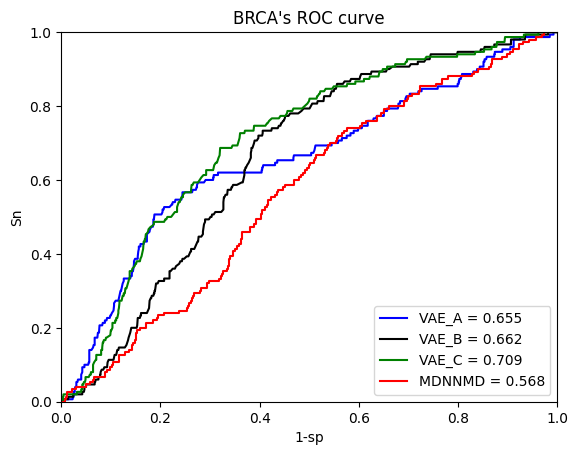

In [9]:
# vae_a_y_pred = np.amin(vae_a_y_pred, axis=1)
vae_a_fpr, vae_a_tpr, vae_a_thresholds = roc_curve(total_vae_a_y_t, total_vae_a_y_pred)
vae_b_fpr, vae_b_tpr, vae_b_thresholds = roc_curve(total_vae_b_y_t, total_vae_b_y_pred)
vae_c_fpr, vae_c_tpr, vae_c_thresholds = roc_curve(total_vae_c_y_t, total_vae_c_y_pred)
mdnnmd_fpr, mdnnmd_tpr, mdnnmd_thresholds = roc_curve(total_cna_y_t, mdnnmd_y_pred )


vae_a_roc_auc = auc(vae_a_fpr, vae_a_tpr)
vae_b_roc_auc = auc(vae_b_fpr, vae_b_tpr)
vae_c_roc_auc = auc(vae_c_fpr, vae_c_tpr)
mdnnmd_roc_auc = auc(mdnnmd_fpr, mdnnmd_tpr)


plt.title("BRCA's ROC curve")
plt.plot(vae_a_fpr, vae_a_tpr, 'blue',label=u'VAE_A = %0.3f'% vae_a_roc_auc)
plt.plot(vae_b_fpr, vae_b_tpr, 'black',label=u'VAE_B = %0.3f'% vae_b_roc_auc)
plt.plot(vae_c_fpr, vae_c_tpr, 'green',label=u'VAE_C = %0.3f'% vae_c_roc_auc)
plt.plot(mdnnmd_fpr, mdnnmd_tpr, 'red',label=u'MDNNMD = %0.3f'% mdnnmd_roc_auc)
plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
ax = plt.gca()
x_major_locator=MultipleLocator(0.2)
y_major_locator=MultipleLocator(0.2)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Sn')
plt.xlabel('1-sp')
# plt.grid(linestyle='-.')
# plt.grid(True)
plt.show()





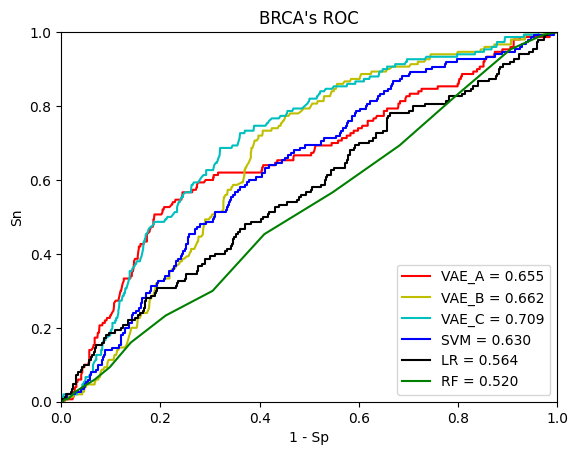

In [10]:
vae_a_fpr, vae_a_tpr, vae_a_thresholds = roc_curve(total_vae_a_y_t, total_vae_a_y_pred)
# vae_b_fpr, vae_b_tpr, vae_b_thresholds = roc_curve(total_vae_b_y_t, total_vae_b_y_pred)
# vae_c_fpr, vae_c_tpr, vae_c_thresholds = roc_curve(total_vae_c_y_t, total_vae_c_y_pred)
svm_fpr, svm_tpr, svm_threshold = roc_curve(svm_y, svm_pred)
lr_fpr, lr_tpr, lr_threshold = roc_curve(lr_y, lr_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(rf_y, rf_pred)

vae_a_roc_auc = auc(vae_a_fpr, vae_a_tpr)
# vae_b_roc_auc = auc(vae_b_fpr, vae_b_tpr)
# vae_c_roc_auc = auc(vae_c_fpr, vae_c_tpr)
svm_roc_auc = auc(svm_fpr,svm_tpr)
lr_roc_auc = auc(lr_fpr, lr_tpr)
rf_roc_auc = auc(rf_fpr, rf_tpr)


plt.figure()
plt.plot(vae_a_fpr, vae_a_tpr, 'r',label=u'VAE_A = %0.3f'% vae_a_roc_auc)
plt.plot(vae_b_fpr, vae_b_tpr, 'y',label=u'VAE_B = %0.3f'% vae_b_roc_auc)
plt.plot(vae_c_fpr, vae_c_tpr, 'c',label=u'VAE_C = %0.3f'% vae_c_roc_auc)
plt.plot(svm_fpr, svm_tpr, c='blue', label=u'SVM = %0.3f' % svm_roc_auc)
plt.plot(lr_fpr, lr_tpr, c='black', label=u'LR = %0.3f' % lr_roc_auc)
plt.plot(rf_fpr, rf_tpr, c='green', label=u'RF = %0.3f' % rf_roc_auc)



plt.title("BRCA's ROC")  # 设置标题
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('1 - Sp')
plt.ylabel('Sn')
plt.legend(loc='lower right')
plt.show()


In [11]:
%%time
#VAE_A
#Clinical Network
#DataSet
class TcbbDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(TcbbDataset, self).__init__()
        self.data = pd.read_csv(data_path)
        self.label = pd.read_csv(label_path)
        self.label = self.label.astype(float)
        self.x_data = torch.tensor(self.data.values, dtype=torch.float32)
        self.y_data = torch.tensor(self.label.values, dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return len(self.x_data)

clincal_dataset = TcbbDataset(clincal_data_path, label_data_path)
in_features = clincal_dataset.x_data.shape[1]

#Net Structure
class Sample(nn.Module):
    def __init__(self):
        super(Sample, self).__init__()
    def forward(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.shape)
        eps = eps.to(device)
        std = torch.exp(z_log_var / 2)
        out = z_mean + std*eps
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
        self.z_mean = nn.Linear(32, 6)
        self.z_log_var = nn.Linear(32, 6)
        self.sample = Sample()

    def forward(self, x):
        out = self.model(x)
        z_mean = self.z_mean(out)
        z_log_var = self.z_log_var(out)
        out = self.sample(z_mean, z_log_var)
        return out, z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 50),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )

    def forward(self, z):
        out = self.model(z)
        return out

class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 200, bias = True), #input layer
            nn.BatchNorm1d(200, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(200, 400, bias = True), # 1 hidden layer
            nn.BatchNorm1d(400, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(400, 100, bias = True), # 2 hidden layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

class VAE_A(nn.Module):
    def __init__(self):
        super(VAE_A, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classfier = Classfier()
    def forward(self, x):
        x, mean, var = self.encoder(x)
        x = self.decoder(x)
        x = self.classfier(x)
        return x
class Classf(nn.Module):
    def __init__(self):
        super(Classf, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 100, bias = True), #input layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x
#Divide DataSet
kfold = KFold(n_splits = 5)
total_clincal_fpr = 0
total_clincal_tpr = 0
total_clincal_a_y_pred = 0
total_clincal_a_y_t = 0
num_epoch = 100
max_accuracy = 0
Clincal_A_Model = Classf()
Clincal_A_Model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(Clincal_A_Model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
k_num = 1

for train_idx, valid_idx in kfold.split(clincal_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    clincal_train_set = Subset(clincal_dataset, train_idx)
    clincal_test_set = Subset(clincal_dataset, valid_idx)
    clincal_train_set, clincal_valid_set = train_test_split(clincal_train_set, test_size=0.2)
    clincal_train_dataloader = DataLoader(clincal_train_set, batch_size=len(clincal_train_set))
    clincal_valid_dataloader = DataLoader(clincal_valid_set, batch_size=len(clincal_test_set))
    clincal_test_dataloader = DataLoader(clincal_test_set, batch_size = len(clincal_test_set))
    for epoch in tqdm(range(num_epoch)):
        #Train
        Clincal_A_Model.train()
        for data in clincal_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = Clincal_A_Model(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #Eval
        Clincal_A_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in clincal_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = Clincal_A_Model(x_data)
                # print(y_pred
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        # print("Validation set's Loss：{}".format(total_test_loss/num_epoch))
        if((total_accuracy/len(clincal_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(clincal_valid_set)
            torch.save(Clincal_A_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/Clincal_A_Model_Best.pth")
    #Clincal TEST
    clincal_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/Clincal_A_Model_Best.pth')
    clincal_model.eval()
    with torch.no_grad():
        for data in clincal_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = clincal_model(x_data)
            y_t = y_t.squeeze(dim = 1)

            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            clincal_y_pred = np.amin(y_pred, axis=1)
            clincal_y_t = y_t

            total_clincal_a_y_pred = np.r_[clincal_y_pred, total_clincal_a_y_pred]
            total_clincal_a_y_t = np.r_[clincal_y_t, total_clincal_a_y_t]

#Gene_Exp Network
#DataSet
gene_dataset = TcbbDataset(gene_data_path, label_data_path)
in_features = gene_dataset.x_data.shape[1]

#Divide DataSet
total_gene_a_y_pred = 0
total_gene_a_y_t =0
Gene_A_Model = VAE_A()
Gene_A_Model.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(Gene_A_Model.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
k_num = 1
for train_idx, valid_idx in kfold.split(gene_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    gene_train_set = Subset(gene_dataset, train_idx)
    gene_test_set = Subset(gene_dataset, valid_idx)
    gene_train_set, gene_valid_set = train_test_split(gene_train_set, test_size=0.2)
    gene_train_dataloader = DataLoader(gene_train_set, batch_size=len(gene_train_set))
    gene_valid_dataloader = DataLoader(gene_valid_set, batch_size=len(gene_valid_set))
    gene_test_dataloader = DataLoader(gene_test_set, batch_size = len(gene_test_set))
    for epoch in tqdm(range(num_epoch)):
        #Train
        Gene_A_Model.train()
        for data in gene_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = Gene_A_Model(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Gene_A_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in gene_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = Gene_A_Model(x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(gene_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(gene_valid_set)
            torch.save(Gene_A_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/Gene_A_Model_Best.pth")

    gene_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/Gene_A_Model_Best.pth')
    gene_model.eval()
    with torch.no_grad():
        for data in gene_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = gene_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            gene_y_pred = np.amin(y_pred, axis=1)
            gene_y_t = y_t

            total_gene_a_y_pred = np.r_[total_gene_a_y_pred, gene_y_pred]
            total_gene_a_y_t = np.r_[total_gene_a_y_t, gene_y_t]

#CNA_Exp Network
#DataSet
cna_dataset = TcbbDataset(cna_data_path, label_data_path)
in_features = cna_dataset.x_data.shape[1]

#Divide DataSet
max_accuracy = 0
k_num = 1
total_cna_a_y_pred = 0
total_cna_a_y_t = 0
CNA_A_Model = VAE_A()
CNA_A_Model.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(CNA_A_Model.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
for train_idx, valid_idx in kfold.split(cna_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    cna_train_set = Subset(cna_dataset, train_idx)
    cna_test_set = Subset(cna_dataset, valid_idx)
    cna_train_set, cna_valid_set = train_test_split(cna_train_set, test_size=0.2)
    cna_train_dataloader = DataLoader(cna_train_set, batch_size=len(cna_train_set))
    cna_valid_dataloader = DataLoader(cna_valid_set, batch_size=len(cna_valid_set))
    cna_test_dataloader = DataLoader(cna_test_set, batch_size = len(cna_test_set))

    for epoch in tqdm(range(num_epoch)):
     #Train
        CNA_A_Model.train()
        for data in cna_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = CNA_A_Model(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #Eval
        CNA_A_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in cna_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = CNA_A_Model(x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(cna_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(cna_valid_set)
            torch.save(CNA_MDNNMD, "/data/minwenwen/lixiaoyu/TCGA/Model/CNA_A_Model_Best.pth")

    cna_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/CNA_A_Model_Best.pth')
    cna_model.eval()
    with torch.no_grad():
        for data in cna_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = cna_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            cna_y_pred = np.amin(y_pred, axis=1)
            cna_y_t = y_t

            total_cna_a_y_pred = np.r_[total_cna_a_y_pred, cna_y_pred]
            total_cna_a_y_t = np.r_[total_cna_a_y_t, cna_y_t]


#Microbiome

#CNA_Exp Network
#DataSet
micro_dataset = TcbbDataset(micro_data_path, label_data_path)
in_features = micro_dataset.x_data.shape[1]

#Divide DataSet
max_accuracy = 0
k_num = 1
total_micro_a_y_pred = 0
total_micro_a_y_t = 0
MICRO_A_Model = VAE_A()
MICRO_A_Model.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(MICRO_A_Model.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
for train_idx, valid_idx in kfold.split(cna_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    micro_train_set = Subset(micro_dataset, train_idx)
    micro_test_set = Subset(micro_dataset, valid_idx)
    micro_train_set, micro_valid_set = train_test_split(micro_train_set, test_size=0.2)
    micro_train_dataloader = DataLoader(micro_train_set, batch_size=len(micro_train_set))
    micro_valid_dataloader = DataLoader(micro_valid_set, batch_size=len(micro_valid_set))
    micro_test_dataloader = DataLoader(micro_test_set, batch_size = len(micro_test_set))

    for epoch in tqdm(range(num_epoch)):
     #Train
        MICRO_A_Model.train()
        for data in micro_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = MICRO_A_Model (x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #Eval
        MICRO_A_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in micro_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = MICRO_A_Model (x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(micro_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(micro_valid_set)
            torch.save(MICRO_A_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/MICRO_A_Model_Best.pth")

    micro_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/MICRO_A_Model_Best.pth')
    micro_model.eval()
    with torch.no_grad():
        for data in micro_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = micro_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            micro_y_pred = np.amin(y_pred, axis=1)
            micro_y_t = y_t

            total_micro_a_y_pred = np.r_[total_micro_a_y_pred, micro_y_pred]
            total_micro_a_y_t = np.r_[total_micro_a_y_t,micro_y_t]


##########第1折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 141.39it/s]


##########第2折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 147.05it/s]


##########第3折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.38it/s]


##########第4折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 148.40it/s]


##########第5折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 150.73it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.24it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.12it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.25it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.34it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.94it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.01it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.79it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.00it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.88it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.57it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.31it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.89it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.42it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.48it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.57it/s]

CPU times: user 44.5 s, sys: 321 ms, total: 44.8 s
Wall time: 44.4 s


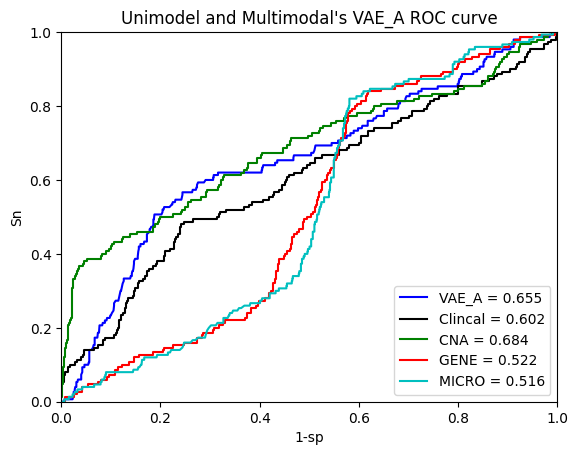

In [12]:
# vae_a_y_pred = np.amin(vae_a_y_pred, axis=1)
vae_a_fpr, vae_a_tpr, vae_a_thresholds = roc_curve(total_vae_a_y_t, total_vae_a_y_pred)
clincal_a_fpr, clincal_a_tpr, clincal_a_thresholds = roc_curve(total_clincal_a_y_t, total_clincal_a_y_pred)
cna_a_fpr, cna_a_tpr, cna_a_thresholds = roc_curve(total_cna_a_y_t, total_cna_a_y_pred)
gene_a_fpr, gene_a_tpr, gene_a_thresholds = roc_curve(total_gene_a_y_t, total_gene_a_y_pred)
micro_a_fpr, micro_a_tpr, micro_a_thresholds = roc_curve(total_micro_a_y_t, total_micro_a_y_pred)


vae_a_roc_auc = auc(vae_a_fpr, vae_a_tpr)
clincal_a_roc_auc = auc(clincal_a_fpr, clincal_a_tpr)
cna_a_roc_auc = auc(cna_a_fpr, cna_a_tpr)
gene_a_roc_auc = auc(gene_a_fpr, gene_a_tpr)
micro_a_roc_auc = auc(micro_a_fpr, micro_a_tpr)


plt.title("Unimodel and Multimodal's VAE_A ROC curve")
plt.plot(vae_a_fpr, vae_a_tpr, 'blue',label=u'VAE_A = %0.3f'% vae_a_roc_auc)
plt.plot(clincal_a_fpr, clincal_a_tpr, 'black',label=u'Clincal = %0.3f'% clincal_a_roc_auc)
plt.plot(cna_a_fpr, cna_a_tpr, 'green',label=u'CNA = %0.3f'% cna_a_roc_auc)
plt.plot(gene_a_fpr, gene_a_tpr, 'red',label=u'GENE = %0.3f'% gene_a_roc_auc)
plt.plot(micro_a_fpr, micro_a_tpr, 'c',label=u'MICRO = %0.3f'% micro_a_roc_auc)
plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
ax = plt.gca()
x_major_locator=MultipleLocator(0.2)
y_major_locator=MultipleLocator(0.2)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Sn')
plt.xlabel('1-sp')
# plt.grid(linestyle='-.')
# plt.grid(True)
plt.show()





In [13]:
%%time
#VAE_B
#Clinical Network
#DataSet
class TcbbDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(TcbbDataset, self).__init__()
        self.data = pd.read_csv(data_path)
        self.label = pd.read_csv(label_path)
        self.label = self.label.astype(float)
        self.x_data = torch.tensor(self.data.values, dtype=torch.float32)
        self.y_data = torch.tensor(self.label.values, dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return len(self.x_data)

clincal_dataset = TcbbDataset(clincal_data_path, label_data_path)
in_features = clincal_dataset.x_data.shape[1]

#Net Structure
class Sample(nn.Module):
    def __init__(self):
        super(Sample, self).__init__()
    def forward(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.shape)
        eps = eps.to(device)
        std = torch.exp(z_log_var / 2)
        out = z_mean + std*eps
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
        self.z_mean = nn.Linear(32, 6)
        self.z_log_var = nn.Linear(32, 6)
        self.sample = Sample()

    def forward(self, x):
        out = self.model(x)
        z_mean = self.z_mean(out)
        z_log_var = self.z_log_var(out)
        out = self.sample(z_mean, z_log_var)
        return out, z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, in_features),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )

    def forward(self, z):
        out = self.model(z)
        return out

class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 200, bias = True), #input layer
            nn.BatchNorm1d(200, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(200, 400, bias = True), # 1 hidden layer
            nn.BatchNorm1d(400, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(400, 100, bias = True), # 2 hidden layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x


class VAE_B(nn.Module):
    def __init__(self):
        super(VAE_B, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classfier = Classfier()
    def forward(self, x):
        x, mean, var = self.encoder(x)
        x = self.decoder(x)
        x = self.classfier(x)
        return x


#Divide DataSet
kfold = KFold(n_splits = 5)
total_clincal_fpr = 0
total_clincal_tpr = 0
total_clincal_b_y_pred = 0
total_clincal_b_y_t = 0
num_epoch = 100
max_accuracy = 0
Clincal_B_Model = Classf()
Clincal_B_Model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(Clincal_B_Model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
k_num = 1

for train_idx, valid_idx in kfold.split(clincal_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    clincal_train_set = Subset(clincal_dataset, train_idx)
    clincal_test_set = Subset(clincal_dataset, valid_idx)
    clincal_train_set, clincal_valid_set = train_test_split(clincal_train_set, test_size=0.2)
    clincal_train_dataloader = DataLoader(clincal_train_set, batch_size=len(clincal_train_set))
    clincal_valid_dataloader = DataLoader(clincal_valid_set, batch_size=len(clincal_test_set))
    clincal_test_dataloader = DataLoader(clincal_test_set, batch_size = len(clincal_test_set))
    for epoch in tqdm(range(num_epoch)):
        #Train
        Clincal_B_Model.train()
        for data in clincal_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = Clincal_B_Model(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #Eval
        Clincal_B_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in clincal_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = Clincal_B_Model(x_data)
                # print(y_pred
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        # print("Validation set's Loss：{}".format(total_test_loss/num_epoch))
        if((total_accuracy/len(clincal_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(clincal_valid_set)
            torch.save(Clincal_A_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/Clincal_B_Model_Best.pth")
    #Clincal TEST
    clincal_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/Clincal_B_Model_Best.pth')
    clincal_model.eval()
    with torch.no_grad():
        for data in clincal_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = clincal_model(x_data)
            y_t = y_t.squeeze(dim = 1)

            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            clincal_y_pred = np.amin(y_pred, axis=1)
            clincal_y_t = y_t

            total_clincal_b_y_pred = np.r_[clincal_y_pred, total_clincal_b_y_pred]
            total_clincal_b_y_t = np.r_[clincal_y_t, total_clincal_b_y_t]

#Gene_Exp Network
#DataSet
gene_dataset = TcbbDataset(gene_data_path, label_data_path)
in_features = gene_dataset.x_data.shape[1]

#Divide DataSet
total_gene_b_y_pred = 0
total_gene_b_y_t =0
Gene_B_Model = VAE_B()
Gene_B_Model.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(Gene_B_Model.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
k_num = 1
for train_idx, valid_idx in kfold.split(gene_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    gene_train_set = Subset(gene_dataset, train_idx)
    gene_test_set = Subset(gene_dataset, valid_idx)
    gene_train_set, gene_valid_set = train_test_split(gene_train_set, test_size=0.2)
    gene_train_dataloader = DataLoader(gene_train_set, batch_size=len(gene_train_set))
    gene_valid_dataloader = DataLoader(gene_valid_set, batch_size=len(gene_valid_set))
    gene_test_dataloader = DataLoader(gene_test_set, batch_size = len(gene_test_set))
    for epoch in tqdm(range(num_epoch)):
        #Train
        Gene_B_Model.train()
        for data in gene_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = Gene_B_Model(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Gene_B_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in gene_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = Gene_B_Model(x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(gene_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(gene_valid_set)
            torch.save(Gene_B_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/Gene_B_Model_Best.pth")

    gene_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/Gene_B_Model_Best.pth')
    gene_model.eval()
    with torch.no_grad():
        for data in gene_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = gene_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            gene_y_pred = np.amin(y_pred, axis=1)
            gene_y_t = y_t

            total_gene_b_y_pred = np.r_[total_gene_b_y_pred, gene_y_pred]
            total_gene_b_y_t = np.r_[total_gene_b_y_t, gene_y_t]

#CNA_Exp Network
#DataSet
cna_dataset = TcbbDataset(cna_data_path, label_data_path)
in_features = cna_dataset.x_data.shape[1]

#Divide DataSet
max_accuracy = 0
k_num = 1
total_cna_b_y_pred = 0
total_cna_b_y_t = 0
CNA_B_Model = VAE_B()
CNA_B_Model.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(CNA_B_Model.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
for train_idx, valid_idx in kfold.split(cna_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    cna_train_set = Subset(cna_dataset, train_idx)
    cna_test_set = Subset(cna_dataset, valid_idx)
    cna_train_set, cna_valid_set = train_test_split(cna_train_set, test_size=0.2)
    cna_train_dataloader = DataLoader(cna_train_set, batch_size=len(cna_train_set))
    cna_valid_dataloader = DataLoader(cna_valid_set, batch_size=len(cna_valid_set))
    cna_test_dataloader = DataLoader(cna_test_set, batch_size = len(cna_test_set))

    for epoch in tqdm(range(num_epoch)):
     #Train
        CNA_B_Model.train()
        for data in cna_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = CNA_B_Model(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #Eval
        CNA_B_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in cna_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = CNA_B_Model(x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(cna_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(cna_valid_set)
            torch.save(CNA_B_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/CNA_B_Model_Best.pth")

    cna_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/CNA_B_Model_Best.pth')
    cna_model.eval()
    with torch.no_grad():
        for data in cna_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = cna_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            cna_y_pred = np.amin(y_pred, axis=1)
            cna_y_t = y_t

            total_cna_b_y_pred = np.r_[total_cna_b_y_pred, cna_y_pred]
            total_cna_b_y_t = np.r_[total_cna_b_y_t, cna_y_t]


#Microbiome

#CNA_Exp Network
#DataSet
micro_dataset = TcbbDataset(micro_data_path, label_data_path)
in_features = micro_dataset.x_data.shape[1]

#Divide DataSet
max_accuracy = 0
k_num = 1
total_micro_b_y_pred = 0
total_micro_b_y_t = 0
MICRO_B_Model = VAE_B()
MICRO_B_Model.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(MICRO_B_Model.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
for train_idx, valid_idx in kfold.split(cna_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    micro_train_set = Subset(micro_dataset, train_idx)
    micro_test_set = Subset(micro_dataset, valid_idx)
    micro_train_set, micro_valid_set = train_test_split(micro_train_set, test_size=0.2)
    micro_train_dataloader = DataLoader(micro_train_set, batch_size=len(micro_train_set))
    micro_valid_dataloader = DataLoader(micro_valid_set, batch_size=len(micro_valid_set))
    micro_test_dataloader = DataLoader(micro_test_set, batch_size = len(micro_test_set))

    for epoch in tqdm(range(num_epoch)):
     #Train
        MICRO_B_Model.train()
        for data in micro_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = MICRO_B_Model (x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #Eval
        MICRO_B_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in micro_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = MICRO_B_Model (x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(micro_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(micro_valid_set)
            torch.save(MICRO_B_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/MICRO_B_Model_Best.pth")

    micro_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/MICRO_B_Model_Best.pth')
    micro_model.eval()
    with torch.no_grad():
        for data in micro_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = micro_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            micro_y_pred = np.amin(y_pred, axis=1)
            micro_y_t = y_t

            total_micro_b_y_pred = np.r_[total_micro_b_y_pred, micro_y_pred]
            total_micro_b_y_t = np.r_[total_micro_b_y_t,micro_y_t]


##########第1折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 143.77it/s]


##########第2折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 150.68it/s]


##########第3折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 150.23it/s]


##########第4折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 148.42it/s]


##########第5折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 148.70it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.69it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.78it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.04it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.19it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.82it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.19it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.85it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.63it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.55it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.86it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.00it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.95it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.21it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.17it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.23it/s]


CPU times: user 44.6 s, sys: 272 ms, total: 44.8 s
Wall time: 44.4 s


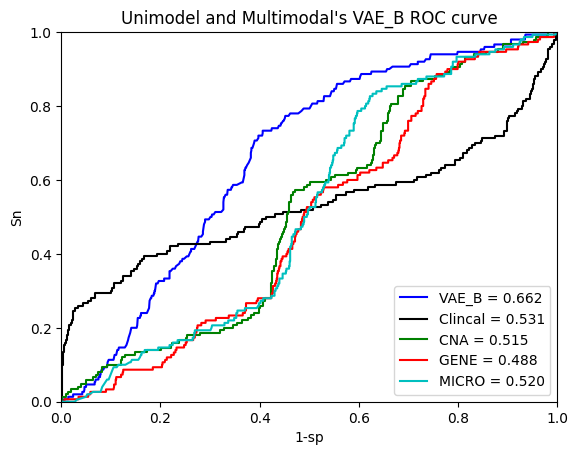

In [14]:
# vae_a_y_pred = np.amin(vae_a_y_pred, axis=1)
vae_b_fpr, vae_b_tpr, vae_b_thresholds = roc_curve(total_vae_b_y_t, total_vae_b_y_pred)
clincal_b_fpr, clincal_b_tpr, clincal_b_thresholds = roc_curve(total_clincal_b_y_t, total_clincal_b_y_pred)
cna_b_fpr, cna_b_tpr, cna_b_thresholds = roc_curve(total_cna_b_y_t, total_cna_b_y_pred)
gene_b_fpr, gene_b_tpr, gene_b_thresholds = roc_curve(total_gene_b_y_t, total_gene_b_y_pred)
micro_b_fpr, micro_b_tpr, micro_b_thresholds = roc_curve(total_micro_b_y_t, total_micro_b_y_pred)


vae_b_roc_auc = auc(vae_b_fpr, vae_b_tpr)
clincal_b_roc_auc = auc(clincal_b_fpr, clincal_b_tpr)
cna_b_roc_auc = auc(cna_b_fpr, cna_b_tpr)
gene_b_roc_auc = auc(gene_b_fpr, gene_b_tpr)
micro_b_roc_auc = auc(micro_b_fpr, micro_b_tpr)


plt.title("Unimodel and Multimodal's VAE_B ROC curve")
plt.plot(vae_b_fpr, vae_b_tpr, 'blue',label=u'VAE_B = %0.3f'% vae_b_roc_auc)
plt.plot(clincal_b_fpr, clincal_b_tpr, 'black',label=u'Clincal = %0.3f'% clincal_b_roc_auc)
plt.plot(cna_b_fpr, cna_b_tpr, 'green',label=u'CNA = %0.3f'% cna_b_roc_auc)
plt.plot(gene_b_fpr, gene_b_tpr, 'red',label=u'GENE = %0.3f'% gene_b_roc_auc)
plt.plot(micro_b_fpr, micro_b_tpr, 'c',label=u'MICRO = %0.3f'% micro_b_roc_auc)
plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
ax = plt.gca()
x_major_locator=MultipleLocator(0.2)
y_major_locator=MultipleLocator(0.2)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Sn')
plt.xlabel('1-sp')
# plt.grid(linestyle='-.')
# plt.grid(True)
plt.show()





In [15]:
%%time
#VAE_C
#Clinical Network
#DataSet
class TcbbDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(TcbbDataset, self).__init__()
        self.data = pd.read_csv(data_path)
        self.label = pd.read_csv(label_path)
        self.label = self.label.astype(float)
        self.x_data = torch.tensor(self.data.values, dtype=torch.float32)
        self.y_data = torch.tensor(self.label.values, dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return len(self.x_data)

clincal_dataset = TcbbDataset(clincal_data_path, label_data_path)
in_features = clincal_dataset.x_data.shape[1]

#Net Structure
class Sample(nn.Module):
    def __init__(self):
        super(Sample, self).__init__()
    def forward(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.shape)
        eps = eps.to(device)
        std = torch.exp(z_log_var / 2)
        out = z_mean + std*eps
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
        self.z_mean = nn.Linear(32, 6)
        self.z_log_var = nn.Linear(32, 6)
        self.sample = Sample()

    def forward(self, x):
        out = self.model(x)
        z_mean = self.z_mean(out)
        z_log_var = self.z_log_var(out)
        out = self.sample(z_mean, z_log_var)
        return out, z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 50),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )

    def forward(self, z):
        out = self.model(z)
        return out

class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 200, bias = True), #input layer
            nn.BatchNorm1d(200, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(200, 400, bias = True), # 1 hidden layer
            nn.BatchNorm1d(400, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(400, 100, bias = True), # 2 hidden layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

class VAE_C(nn.Module):
    def __init__(self):
        super(VAE_C, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classfier = Classfier()
    def forward(self, x):
        x, mean, var = self.encoder(x)
        # x = self.decoder(x)
        x = self.classfier(x)
        return x

class Classf(nn.Module):
    def __init__(self):
        super(Classf, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 100, bias = True), #input layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x
#Divide DataSet
kfold = KFold(n_splits = 5)
total_clincal_fpr = 0
total_clincal_tpr = 0
total_clincal_c_y_pred = 0
total_clincal_c_y_t = 0
num_epoch = 100
max_accuracy = 0
Clincal_C_Model = Classf()
Clincal_C_Model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(Clincal_C_Model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
k_num = 1

for train_idx, valid_idx in kfold.split(clincal_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    clincal_train_set = Subset(clincal_dataset, train_idx)
    clincal_test_set = Subset(clincal_dataset, valid_idx)
    clincal_train_set, clincal_valid_set = train_test_split(clincal_train_set, test_size=0.2)
    clincal_train_dataloader = DataLoader(clincal_train_set, batch_size=len(clincal_train_set))
    clincal_valid_dataloader = DataLoader(clincal_valid_set, batch_size=len(clincal_test_set))
    clincal_test_dataloader = DataLoader(clincal_test_set, batch_size = len(clincal_test_set))
    for epoch in tqdm(range(num_epoch)):
        #Train
        Clincal_C_Model.train()
        for data in clincal_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = Clincal_C_Model(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #Eval
        Clincal_C_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in clincal_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = Clincal_C_Model(x_data)
                # print(y_pred
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        # print("Validation set's Loss：{}".format(total_test_loss/num_epoch))
        if((total_accuracy/len(clincal_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(clincal_valid_set)
            torch.save(Clincal_C_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/Clincal_C_Model_Best.pth")
    #Clincal TEST
    clincal_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/Clincal_C_Model_Best.pth')
    clincal_model.eval()
    with torch.no_grad():
        for data in clincal_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = clincal_model(x_data)
            y_t = y_t.squeeze(dim = 1)

            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            clincal_y_pred = np.amin(y_pred, axis=1)
            clincal_y_t = y_t

            total_clincal_c_y_pred = np.r_[clincal_y_pred, total_clincal_c_y_pred]
            total_clincal_c_y_t = np.r_[clincal_y_t, total_clincal_c_y_t]

#Gene_Exp Network
#DataSet
gene_dataset = TcbbDataset(gene_data_path, label_data_path)
in_features = gene_dataset.x_data.shape[1]

#Divide DataSet
total_gene_c_y_pred = 0
total_gene_c_y_t =0
Gene_C_Model = VAE_C()
Gene_C_Model.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(Gene_C_Model.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
k_num = 1
for train_idx, valid_idx in kfold.split(gene_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    gene_train_set = Subset(gene_dataset, train_idx)
    gene_test_set = Subset(gene_dataset, valid_idx)
    gene_train_set, gene_valid_set = train_test_split(gene_train_set, test_size=0.2)
    gene_train_dataloader = DataLoader(gene_train_set, batch_size=len(gene_train_set))
    gene_valid_dataloader = DataLoader(gene_valid_set, batch_size=len(gene_valid_set))
    gene_test_dataloader = DataLoader(gene_test_set, batch_size = len(gene_test_set))
    for epoch in tqdm(range(num_epoch)):
        #Train
        Gene_C_Model.train()
        for data in gene_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = Gene_C_Model(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Gene_C_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in gene_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = Gene_C_Model(x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(gene_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(gene_valid_set)
            torch.save(Gene_C_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/Gene_C_Model_Best.pth")

    gene_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/Gene_C_Model_Best.pth')
    gene_model.eval()
    with torch.no_grad():
        for data in gene_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = gene_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            gene_y_pred = np.amin(y_pred, axis=1)
            gene_y_t = y_t

            total_gene_c_y_pred = np.r_[total_gene_c_y_pred, gene_y_pred]
            total_gene_c_y_t = np.r_[total_gene_c_y_t, gene_y_t]

#CNA_Exp Network
#DataSet
cna_dataset = TcbbDataset(cna_data_path, label_data_path)
in_features = cna_dataset.x_data.shape[1]

#Divide DataSet
max_accuracy = 0
k_num = 1
total_cna_c_y_pred = 0
total_cna_c_y_t = 0
CNA_C_Model = VAE_C()
CNA_C_Model.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(CNA_C_Model.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
for train_idx, valid_idx in kfold.split(cna_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    cna_train_set = Subset(cna_dataset, train_idx)
    cna_test_set = Subset(cna_dataset, valid_idx)
    cna_train_set, cna_valid_set = train_test_split(cna_train_set, test_size=0.2)
    cna_train_dataloader = DataLoader(cna_train_set, batch_size=len(cna_train_set))
    cna_valid_dataloader = DataLoader(cna_valid_set, batch_size=len(cna_valid_set))
    cna_test_dataloader = DataLoader(cna_test_set, batch_size = len(cna_test_set))

    for epoch in tqdm(range(num_epoch)):
     #Train
        CNA_C_Model.train()
        for data in cna_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = CNA_C_Model(x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #Eval
        CNA_C_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in cna_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = CNA_C_Model(x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(cna_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(cna_valid_set)
            torch.save(CNA_C_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/CNA_C_Model_Best.pth")

    cna_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/CNA_C_Model_Best.pth')
    cna_model.eval()
    with torch.no_grad():
        for data in cna_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = cna_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            cna_y_pred = np.amin(y_pred, axis=1)
            cna_y_t = y_t

            total_cna_c_y_pred = np.r_[total_cna_c_y_pred, cna_y_pred]
            total_cna_c_y_t = np.r_[total_cna_c_y_t, cna_y_t]


#Microbiome

#CNA_Exp Network
#DataSet
micro_dataset = TcbbDataset(micro_data_path, label_data_path)
in_features = micro_dataset.x_data.shape[1]

#Divide DataSet
max_accuracy = 0
k_num = 1
total_micro_c_y_pred = 0
total_micro_c_y_t = 0
MICRO_C_Model = VAE_C()
MICRO_C_Model.to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(MICRO_C_Model.parameters(),lr=learning_rate) # 优化器使用Adam，传入网络参数和学习率
criterion = nn.CrossEntropyLoss()# 损失函数使用交叉熵损失函数
criterion.to(device)
# num_epoch = 100
max_accuracy = 0
for train_idx, valid_idx in kfold.split(cna_dataset):
    print("##########第{}折##########".format(k_num))
    k_num = k_num + 1
    micro_train_set = Subset(micro_dataset, train_idx)
    micro_test_set = Subset(micro_dataset, valid_idx)
    micro_train_set, micro_valid_set = train_test_split(micro_train_set, test_size=0.2)
    micro_train_dataloader = DataLoader(micro_train_set, batch_size=len(micro_train_set))
    micro_valid_dataloader = DataLoader(micro_valid_set, batch_size=len(micro_valid_set))
    micro_test_dataloader = DataLoader(micro_test_set, batch_size = len(micro_test_set))

    for epoch in tqdm(range(num_epoch)):
     #Train
        MICRO_C_Model.train()
        for data in micro_train_dataloader:
            x_data, y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_t = y_t.squeeze(dim = 1)
            y_pred = MICRO_C_Model (x_data)
            loss = criterion(y_pred, y_t.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #Eval
        MICRO_C_Model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data in micro_valid_dataloader:
                x_data , y_t = data
                x_data = x_data.to(device)
                y_t = y_t.to(device)
                y_pred = MICRO_C_Model (x_data)
                y_t = y_t.squeeze(dim = 1)
                loss = criterion(y_pred, y_t.long())
                total_test_loss = total_test_loss + loss.item()
                accuracy = (y_pred.argmax(1) == y_t).sum()
                total_accuracy = total_accuracy + accuracy
        if((total_accuracy/len(micro_valid_set)) > max_accuracy):
            max_accuracy = total_accuracy/len(micro_valid_set)
            torch.save(MICRO_C_Model, "/data/minwenwen/lixiaoyu/TCGA/Model/MICRO_C_Model_Best.pth")

    micro_model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/MICRO_C_Model_Best.pth')
    micro_model.eval()
    with torch.no_grad():
        for data in micro_test_dataloader:
            x_data , y_t = data
            x_data = x_data.to(device)
            y_t = y_t.to(device)
            y_pred = micro_model(x_data)
            y_t = y_t.squeeze(dim = 1)
            acc_tmp = (y_pred.argmax(1) == y_t).sum()
            y_t = y_t.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            micro_y_pred = np.amin(y_pred, axis=1)
            micro_y_t = y_t

            total_micro_c_y_pred = np.r_[total_micro_c_y_pred, micro_y_pred]
            total_micro_c_y_t = np.r_[total_micro_c_y_t,micro_y_t]


##########第1折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 140.21it/s]


##########第2折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 118.75it/s]


##########第3折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 153.92it/s]


##########第4折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 152.41it/s]


##########第5折##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 149.85it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.86it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.13it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.97it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.97it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.61it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.35it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.80it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.17it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.67it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.88it/s]


##########第1折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.71it/s]


##########第2折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.33it/s]


##########第3折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


##########第4折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.23it/s]


##########第5折##########


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.71it/s]

CPU times: user 36.7 s, sys: 275 ms, total: 37 s
Wall time: 36.6 s


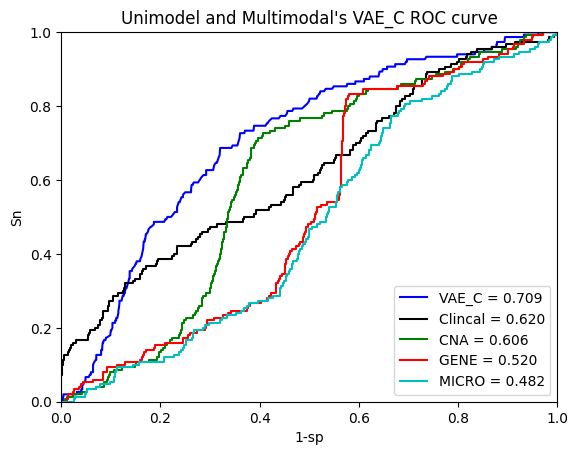

In [16]:
# vae_a_y_pred = np.amin(vae_a_y_pred, axis=1)
vae_c_fpr, vae_c_tpr, vae_c_thresholds = roc_curve(total_vae_c_y_t, total_vae_c_y_pred)
clincal_c_fpr, clincal_c_tpr, clincal_c_thresholds = roc_curve(total_clincal_c_y_t, total_clincal_c_y_pred)
cna_c_fpr, cna_c_tpr, cna_c_thresholds = roc_curve(total_cna_c_y_t, total_cna_c_y_pred)
gene_c_fpr, gene_c_tpr, gene_c_thresholds = roc_curve(total_gene_c_y_t, total_gene_c_y_pred)
micro_c_fpr, micro_c_tpr, micro_c_thresholds = roc_curve(total_micro_c_y_t, total_micro_c_y_pred)


vae_c_roc_auc = auc(vae_c_fpr, vae_c_tpr)
clincal_c_roc_auc = auc(clincal_c_fpr, clincal_c_tpr)
cna_c_roc_auc = auc(cna_c_fpr, cna_c_tpr)
gene_c_roc_auc = auc(gene_c_fpr, gene_c_tpr)
micro_c_roc_auc = auc(micro_c_fpr, micro_c_tpr)


plt.title("Unimodel and Multimodal's VAE_C ROC curve")
plt.plot(vae_c_fpr, vae_c_tpr, 'blue',label=u'VAE_C = %0.3f'% vae_c_roc_auc)
plt.plot(clincal_c_fpr, clincal_c_tpr, 'black',label=u'Clincal = %0.3f'% clincal_c_roc_auc)
plt.plot(cna_c_fpr, cna_c_tpr, 'green',label=u'CNA = %0.3f'% cna_c_roc_auc)
plt.plot(gene_c_fpr, gene_c_tpr, 'red',label=u'GENE = %0.3f'% gene_c_roc_auc)
plt.plot(micro_c_fpr, micro_c_tpr, 'c',label=u'MICRO = %0.3f'% micro_c_roc_auc)
plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
ax = plt.gca()
x_major_locator=MultipleLocator(0.2)
y_major_locator=MultipleLocator(0.2)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Sn')
plt.xlabel('1-sp')
# plt.grid(linestyle='-.')
# plt.grid(True)
plt.show()



